In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

sns.set_style('whitegrid')

# Problem definition

Cluster counties based on demographic and economic data

https://www.kaggle.com/muonneutrino/us-census-demographic-data/data

# Load the data

In [5]:
#input
df = pd.read_csv('data/flightsmerged.csv', low_memory=False)
df = df.set_index(['MONTH', 'FLIGHT_NUMBER', 'ORIGIN_STATE'])
df.head()

TAIL_NUMBER SCHEDULED_DEPARTURE  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                   
1     98            AK                N407AS            00:05:00   
      2336          CA                N3KUAA            00:10:00   
      840           CA                N171US            00:20:00   
      258           CA                N3HYAA            00:20:00   
      135           WA                N527AS            00:25:00   

                                 DEPARTURE_TIME  DEPARTURE_DELAY  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                   
1     98            AK                 23:54:00            -11.0   
      2336          CA                 00:02:00             -8.0   
      840           CA                 00:18:00             -2.0   
      258           CA                 00:15:00             -5.0   
      135           WA                 00:24:00             -1.0   

                                  SCHEDULED_TIME  DISTANCE SCHEDULED_ARRIVAL  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                               
1     98            AK                     205.0      1448          04:30:00   
      2336          CA                     280.0      2330          07:50:00   
      840           CA                     286.0      2296          08:06:00   
      258           CA                     285.0      2342          08:05:00   
      135           WA                     235.0      1448          03:20:00   

                                 ARRIVAL_TIME  ARRIVAL_DELAY  DIVERTED  ...  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                        ...   
1     98            AK               04:08:00          -22.0     False  ...   
      2336          CA               07:41:00           -9.0     False  ...   
      840           CA               08:11:00            5.0     False  ...   
      258           CA               07:56:00           -9.0     False  ...   
      135           WA               02:59:00          -21.0     False  ...   

                                            AIRLINE_NAME ORIGIN_AC  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                     
1     98            AK              Alaska Airlines Inc.       ANC   
      2336          CA            American Airlines Inc.       LAX   
      840           CA                   US Airways Inc.       SFO   
      258           CA            American Airlines Inc.       LAX   
      135           WA              Alaska Airlines Inc.       SEA   

                                                                  ORIGIN_NAME  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                                
1     98            AK            Ted Stevens Anchorage International Airport   
      2336          CA                      Los Angeles International Airport   
      840           CA                    San Francisco International Airport   
      258           CA                      Los Angeles International Airport   
      135           WA                   Seattle-Tacoma International Airport   

                                  ORIGIN_LATITUDE  ORIGIN_LONGITUDE  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                      
1     98            AK                   61.17432        -149.99619   
      2336          CA                   33.94254        -118.40807   
      840           CA                   37.61900        -122.37484   
      258           CA                   33.94254        -118.40807   
      135           WA                   47.44898        -122.30931   

                                  DESTINATION_AC  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                   
1     98            AK                       SEA   
      2336          CA                       PBI   
      840           CA                       CLT   
      258           CA                       MIA   
      135           WA                       ANC   

                                          

# Feature Engineering 

In [11]:
from sklearn.preprocessing import LabelEncoder
for column in df.columns:
    if df[column].dtype == type(object):
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

In [12]:
# remove NaNs
df = df.dropna()

# remove column
X_columns = list(df.columns)
if 'IncomeErr' in X_columns:
    X_columns.remove('IncomeErr')
if 'IncomePerCapErr' in X_columns:
    X_columns.remove('IncomePerCapErr')
df = df[X_columns]

# normalize the columns
df_norm = df.copy()
for col in X_columns:
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))

print(df.shape)
df_norm.head()

/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarni

(5119373, 30)


TAIL_NUMBER  SCHEDULED_DEPARTURE  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                     
1     98            AK              -0.659136            -2.339075   
      2336          CA              -0.705382            -2.321848   
      840           CA              -1.500672            -2.287394   
      258           CA              -0.733410            -2.287394   
      135           WA              -0.302482            -2.270167   

                                  DEPARTURE_TIME  DEPARTURE_DELAY  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                    
1     98            AK                  2.108791        -0.808564   
      2336          CA                 -2.728262        -0.662863   
      840           CA                 -2.674217        -0.371462   
      258           CA                 -2.684350        -0.517163   
      135           WA                 -2.653950        -0.322895   

                                  SCHEDULED_TIME  DISTANCE  SCHEDULED_ARRIVAL  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                                
1     98            AK                  0.834912  1.021612          -2.089793   
      2336          CA                  1.829497  2.469600          -1.432411   
      840           CA                  1.909064  2.413782          -1.379821   
      258           CA                  1.895803  2.489301          -1.383108   
      135           WA                  1.232746  1.021612          -2.300155   

                                  ARRIVAL_TIME  ARRIVAL_DELAY  DIVERTED  ...  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                         ...   
1     98            AK               -2.074360      -0.952351 -0.047094  ...   
      2336          CA               -1.393637      -0.407015 -0.047094  ...   
      840           CA               -1.297760       0.180269 -0.047094  ...   
      258           CA               -1.345698      -0.407015 -0.047094  ...   
      135           WA               -2.294876      -0.910402 -0.047094  ...   

                                  AIRLINE_NAME  ORIGIN_AC  ORIGIN_NAME  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                         
1     98            AK               -1.664364  -1.646380     1.583390   
      2336          CA               -1.394598   0.172266     0.217199   
      840           CA                1.303070   1.334818     1.251073   
      258           CA               -1.394598   0.172266     0.217199   
      135           WA               -1.664364   1.323307     1.349537   

                                  ORIGIN_LATITUDE  ORIGIN_LONGITUDE  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                      
1     98            AK                   4.080171         -2.982066   
      2336          CA                  -0.445544         -1.248950   
      840           CA                   0.165455         -1.466591   
      258           CA                  -0.445544         -1.248950   
      135           WA                   1.799124         -1.462995   

                                  DESTINATION_AC  DESTINATION_NAME  \
MONTH FLIGHT_NUMBER ORIGIN_STATE                                     
1     98            AK                  1.323043          1.348367   
      2336          CA                  0.839604          0.794725   
      840           CA                 -1.082640         -1.296815   
      258           CA                  0.482780          0.474842   
      135           WA                 -1.646652          1.582128   

                                  DEST_STATE  DEST_LATITUDE  DEST_LONGITUDE  
MONTH FLIGHT_NUMBER ORIGIN_STATE                                             
1     98            AK              1.684496       1.799069       -1.463971  
      2336          CA             -0.906731      -1.651137        0.852739  
      840           CA              0.294082      -0.233751        0.806226  
      258           CA          

# Model Training

In [13]:
k = 7
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

{0, 1, 2, 3, 4, 5, 6}
Counter({4: 1642300, 3: 1511845, 1: 849988, 2: 668493, 6: 321833, 0: 113585, 5: 11329})


[('TX', 11897), ('IL', 10645), ('FL', 10204), ('CA', 9140), ('NY', 7903)]
[('CA', 343485), ('AZ', 83637), ('WA', 72997), ('NV', 65343), ('UT', 64504)]
[('CA', 169137), ('IL', 44048), ('TX', 41507), ('NY', 38722), ('NV', 35615)]
[('TX', 249142), ('GA', 169767), ('FL', 154834), ('IL', 141821), ('CO', 74565)]
[('TX', 231661), ('FL', 172411), ('IL', 130260), ('GA', 130012), ('NY', 94234)]
[('TX', 1346), ('CA', 1209), ('FL', 1019), ('IL', 810), ('GA', 652)]
[('TX', 45422), ('CA', 38586), ('IL', 30973), ('FL', 26860), ('GA', 19503)]
TAIL_NUMBER


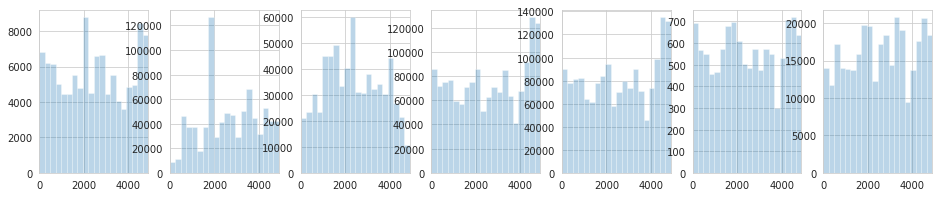

SCHEDULED_DEPARTURE


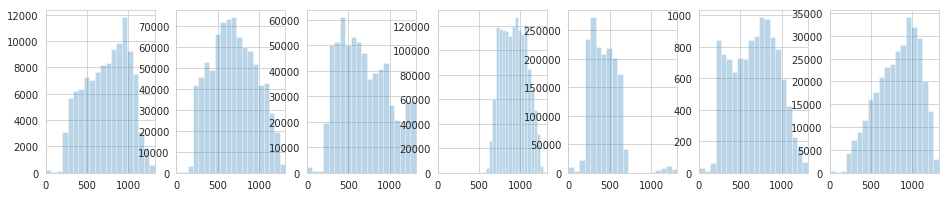

DEPARTURE_TIME


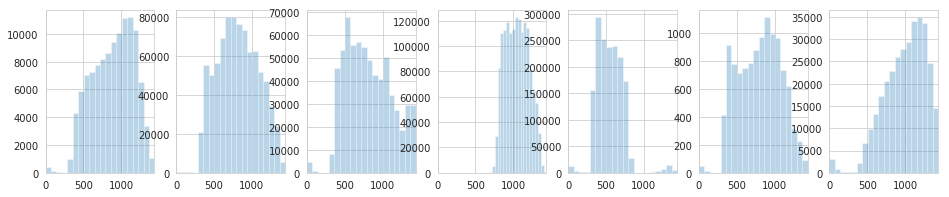

DEPARTURE_DELAY


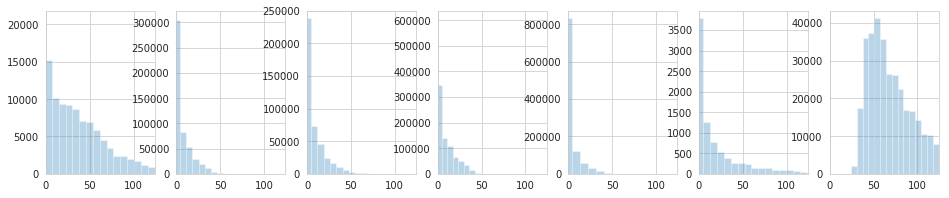

SCHEDULED_TIME


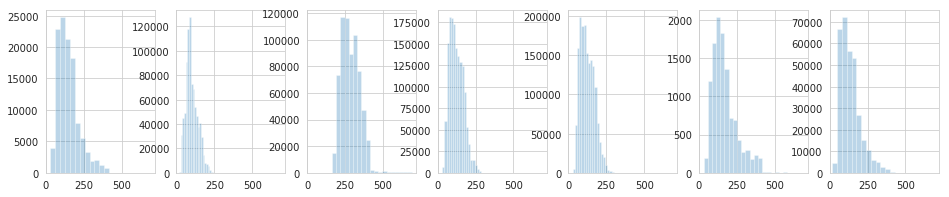

DISTANCE


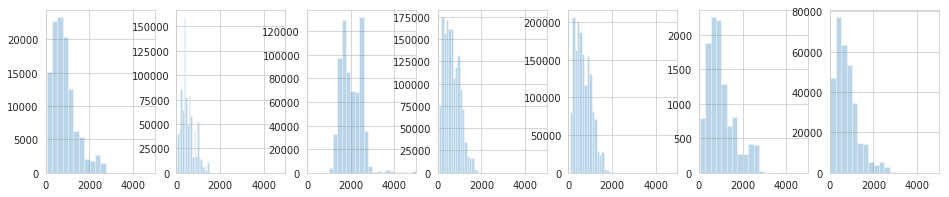

SCHEDULED_ARRIVAL


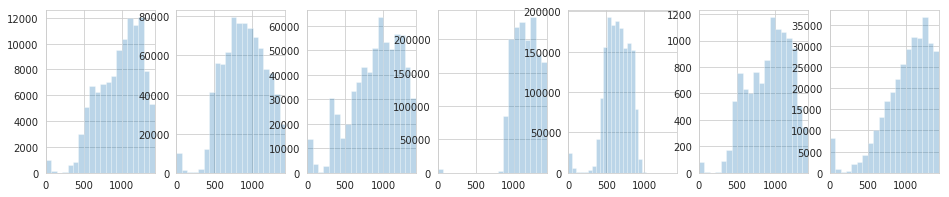

ARRIVAL_TIME


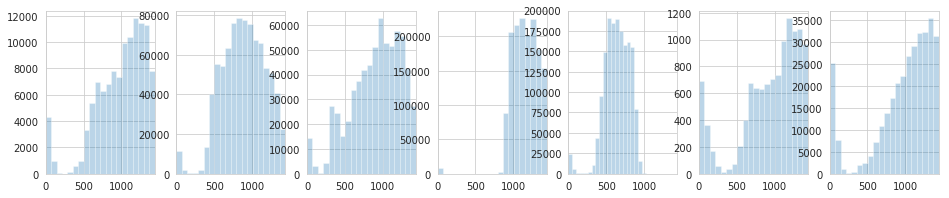

ARRIVAL_DELAY


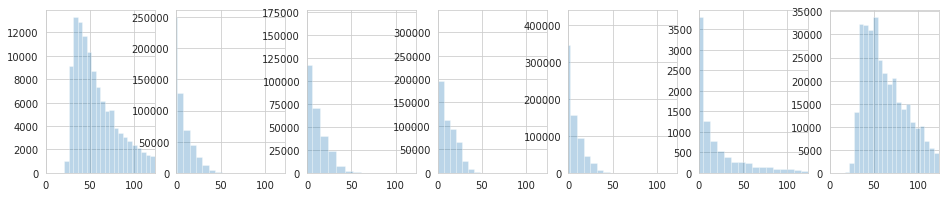

DIVERTED


/home/tiffany/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


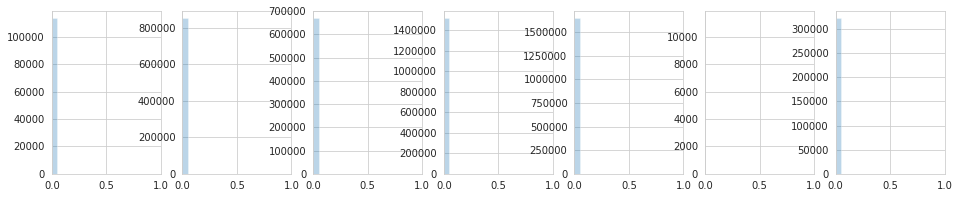

CANCELLED


/home/tiffany/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=False
  ret = ax.set_xlim(*args, **kwargs)
/home/tiffany/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=False
  ret = ax.set_xlim(*args, **kwargs)
/home/tiffany/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=False
  ret = ax.set_xlim(*args, **kwargs)
/home/tiffany/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=False
  ret = ax.set_xlim(*args, **kwar

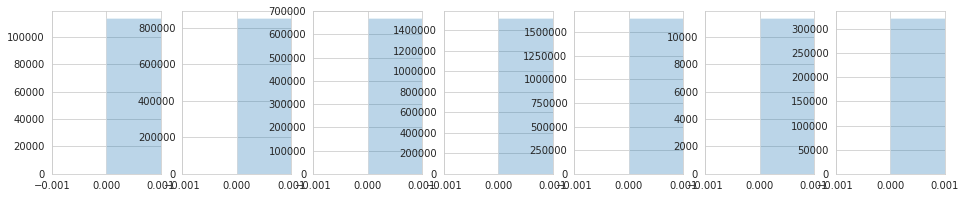

CANCELLATION_REASON


/home/tiffany/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  ret = ax.set_xlim(*args, **kwargs)
/home/tiffany/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  ret = ax.set_xlim(*args, **kwargs)
/home/tiffany/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  ret = ax.set_xlim(*args, **kwargs)
/home/tiffany/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  ret = ax.set_xlim(*args, **kwargs)
/home/tiffan

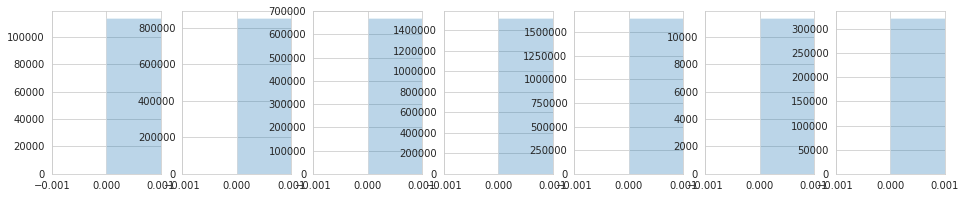

AIR_SYSTEM_DELAY


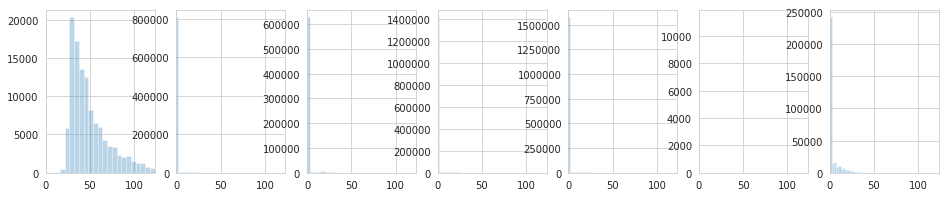

SECURITY_DELAY


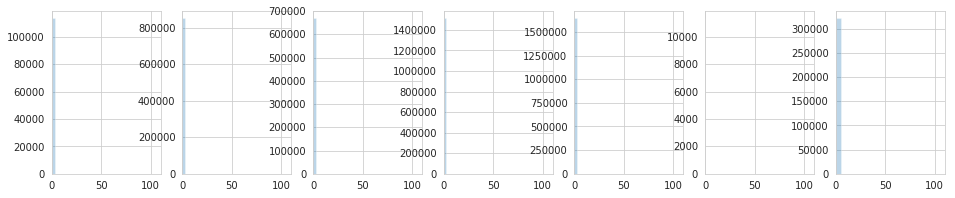

AIRLINE_DELAY


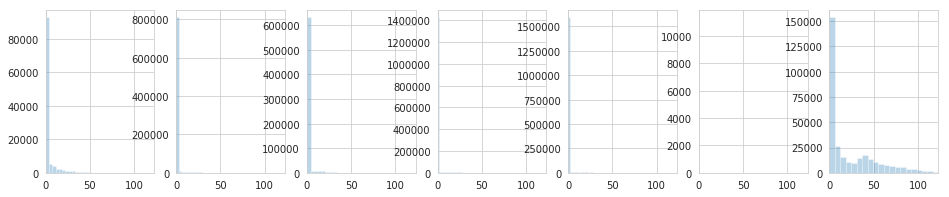

LATE_AIRCRAFT_DELAY


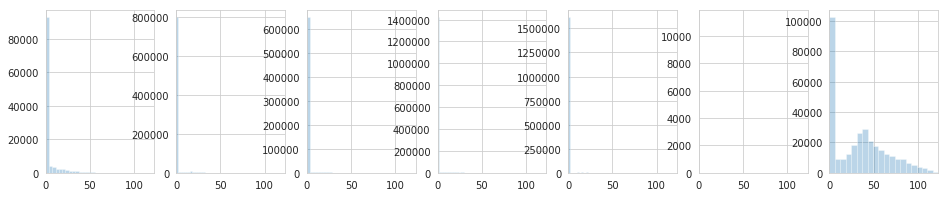

WEATHER_DELAY


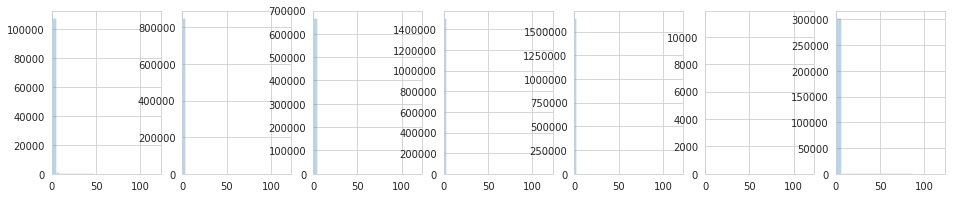

DATE


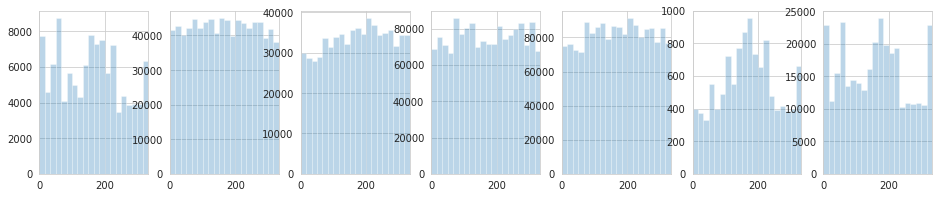

CLASS


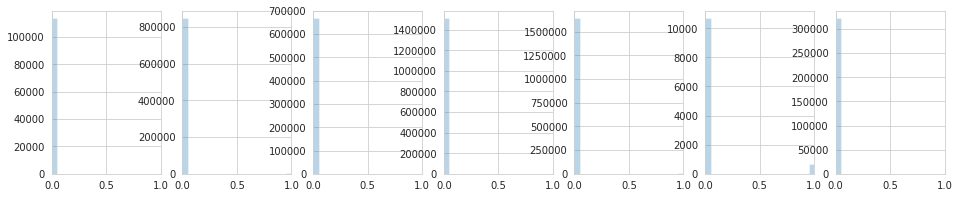

AIRLINE_CODE


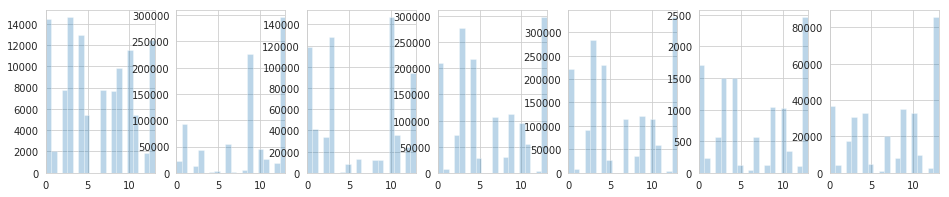

AIRLINE_NAME


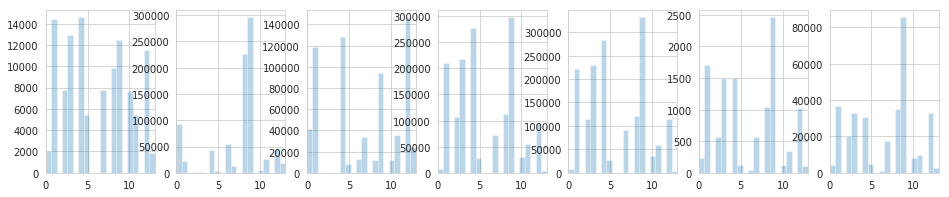

ORIGIN_AC


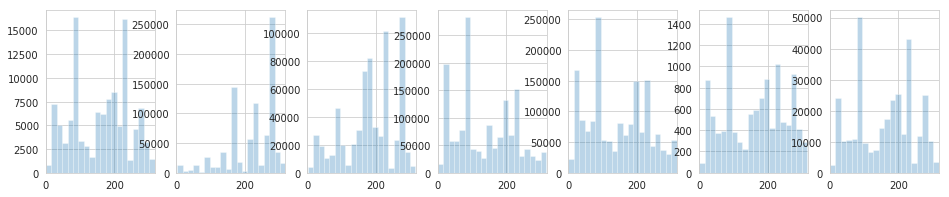

ORIGIN_NAME


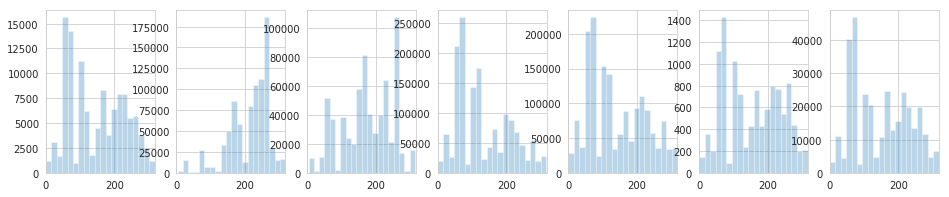

ORIGIN_LATITUDE


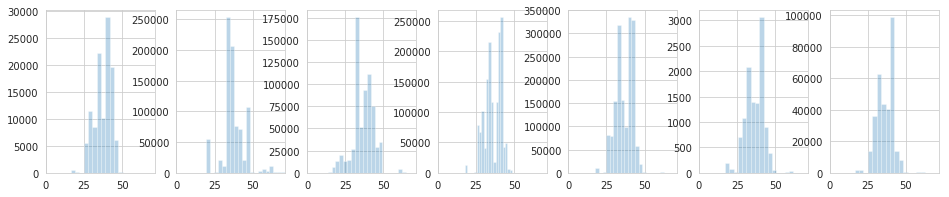

ORIGIN_LONGITUDE


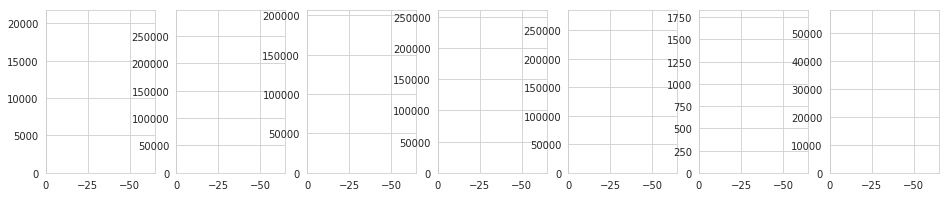

DESTINATION_AC


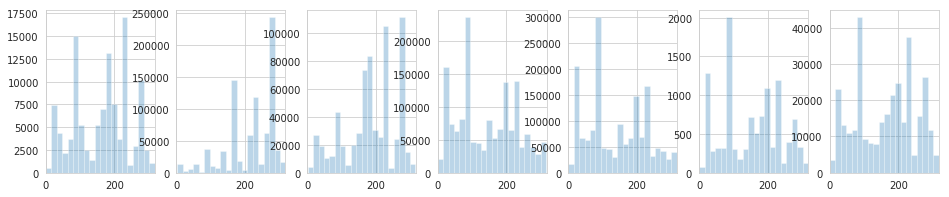

DESTINATION_NAME


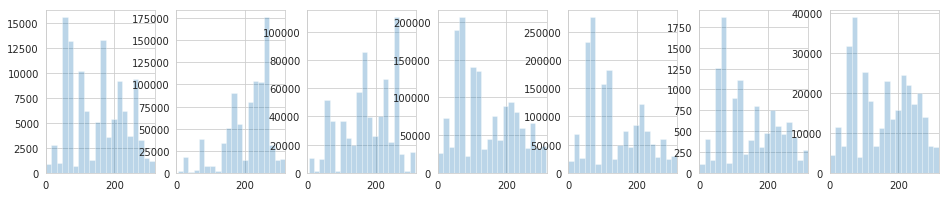

DEST_STATE


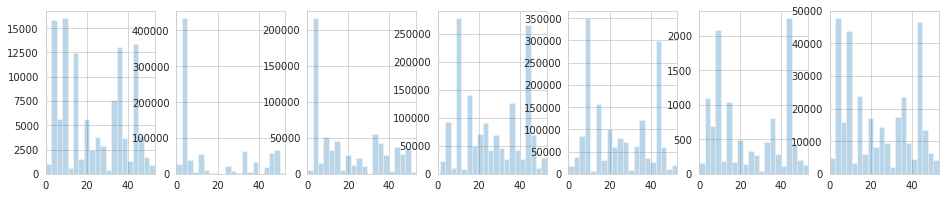

DEST_LATITUDE


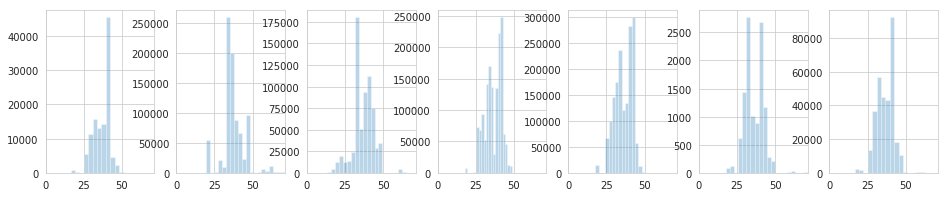

DEST_LONGITUDE


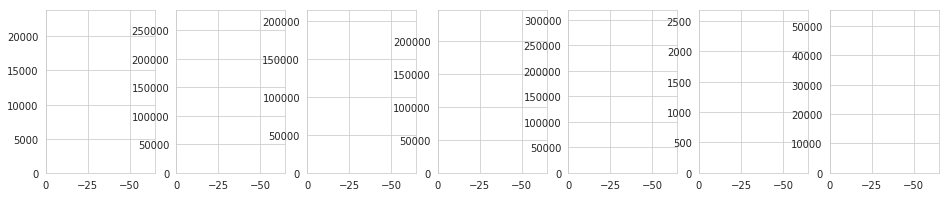

In [15]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(kmeans.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['ORIGIN_STATE']).most_common(5))

n_clusters = len(set(kmeans.labels_))
for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
    plt.show()

In [17]:
# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4,5,6
index,2.40217e+06,2.53134e+06,2.62499e+06,2.56696e+06,2.57185e+06,2.61168e+06,2.45643e+06
MONTH,5.88,6.17,6.37,6.24,6.26,6.32,6
FLIGHT_NUMBER,2134.81,2236.99,1200.83,2354.71,2333.77,2252.61,2280.39
TAIL_NUMBER,2466.53,2648.42,2371.74,2587.01,2581.77,2455.65,2543.06
SCHEDULED_DEPARTURE,735.61,688.33,689.84,919.82,428.98,666.98,818.87
DEPARTURE_TIME,884.08,812.61,810.45,1045.95,549.26,799.54,993.7
DEPARTURE_DELAY,29.07,0.64,2.64,2.13,-1.02,11.47,67.2
SCHEDULED_TIME,147.72,99.98,286.81,122.05,123.85,167.09,136.27
DISTANCE,846.33,521.22,2018.79,650.14,665.37,1013.72,780.85
SCHEDULED_ARRIVAL,971.52,883.96,905.81,1151.26,640.49,921.52,1013.15


TAIL_NUMBER


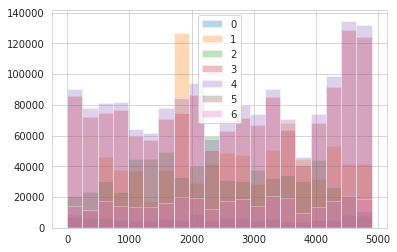

SCHEDULED_DEPARTURE


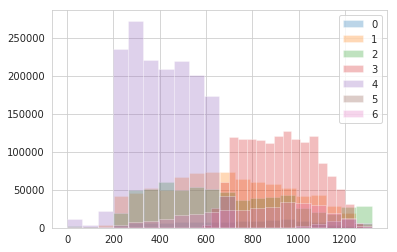

DEPARTURE_TIME


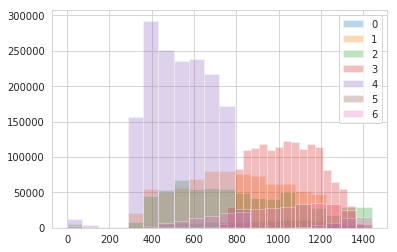

DEPARTURE_DELAY


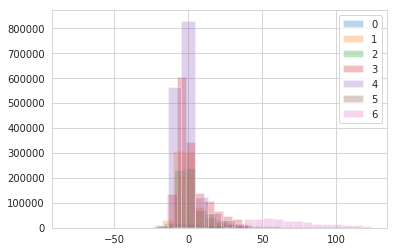

SCHEDULED_TIME


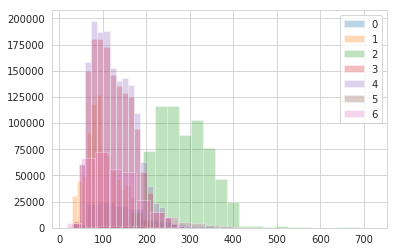

DISTANCE


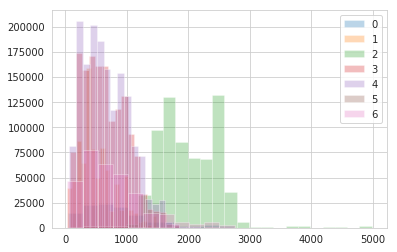

SCHEDULED_ARRIVAL


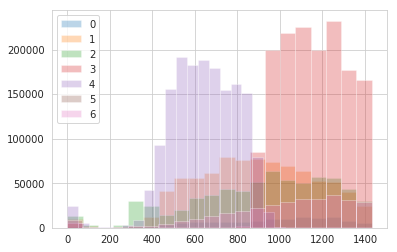

ARRIVAL_TIME


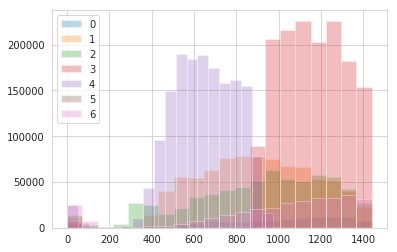

ARRIVAL_DELAY


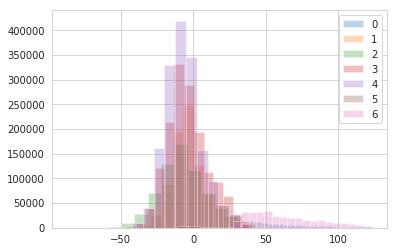

DIVERTED


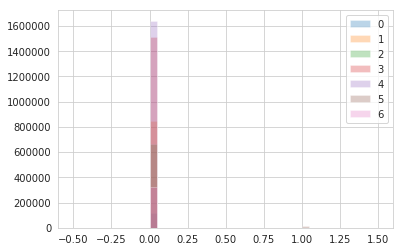

CANCELLED


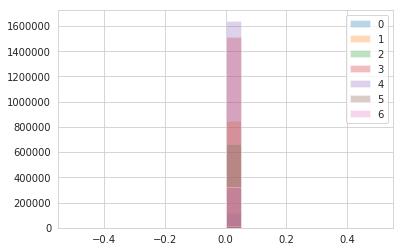

CANCELLATION_REASON


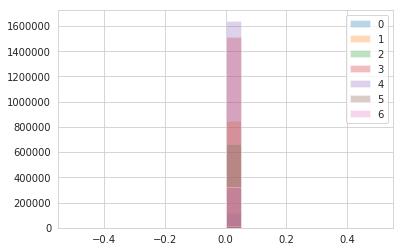

AIR_SYSTEM_DELAY


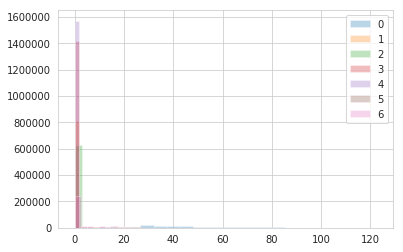

SECURITY_DELAY


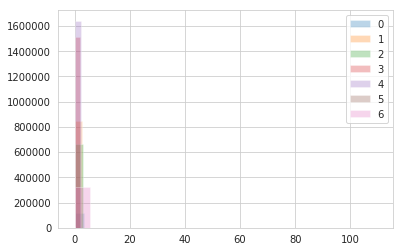

AIRLINE_DELAY


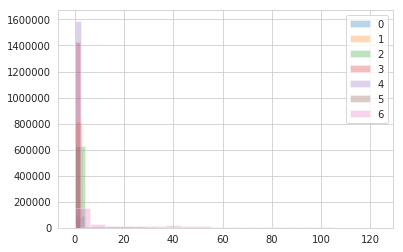

LATE_AIRCRAFT_DELAY


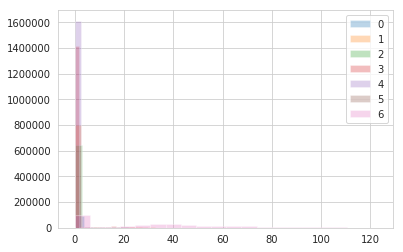

WEATHER_DELAY


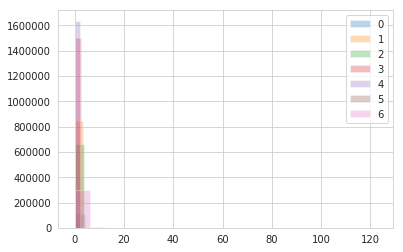

DATE


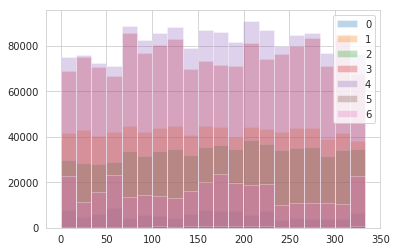

CLASS


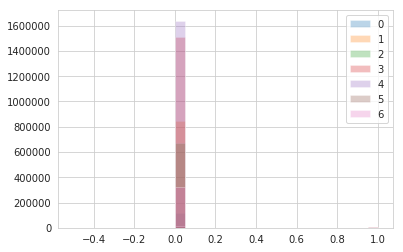

AIRLINE_CODE


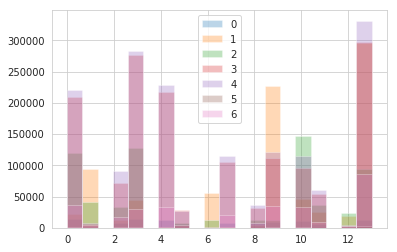

AIRLINE_NAME


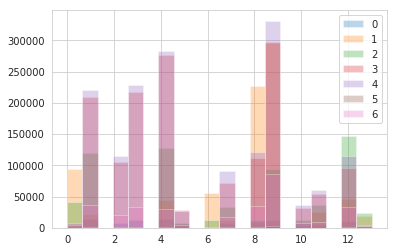

ORIGIN_AC


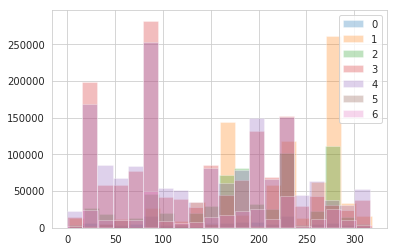

ORIGIN_NAME


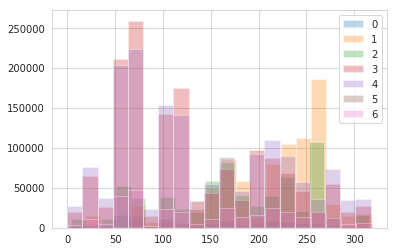

ORIGIN_LATITUDE


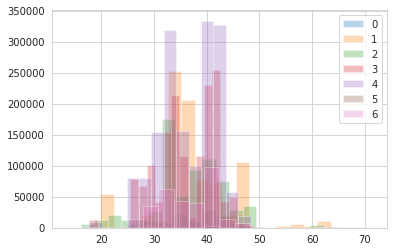

ORIGIN_LONGITUDE


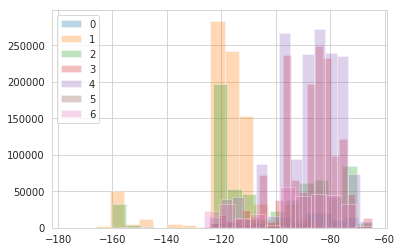

DESTINATION_AC


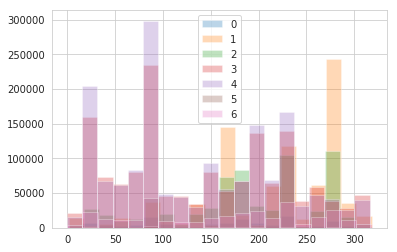

DESTINATION_NAME


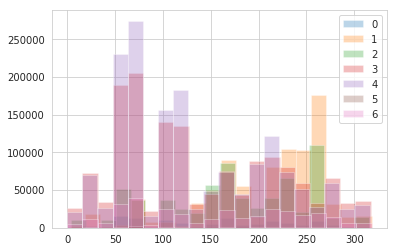

DEST_STATE


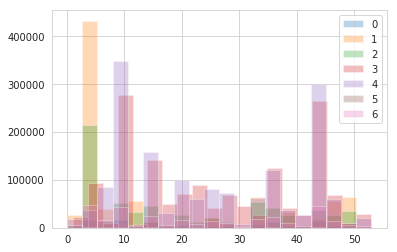

DEST_LATITUDE


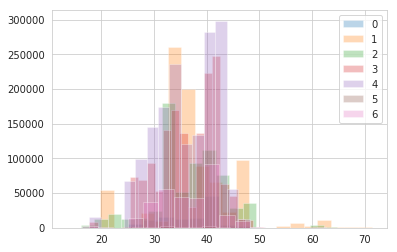

DEST_LONGITUDE


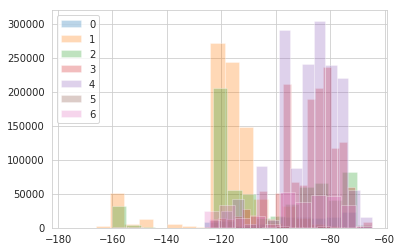

In [18]:
# Analyze the results
for col in X_columns:
    print(col)
    for cluster in set(kmeans.labels_):
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
    plt.legend()
    plt.show()

# Model Evaluation

In [19]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(kmeans.labels_)):
    centroids.append(df_norm[df_norm['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 0.06909707280949626
Intra Cluster distance 0.8640812624573616
Inertia 101758920.82513188


In [20]:
inertia = []
number_k = []
for k in range(2, 100, 10):
    kmeans = KMeans(n_clusters=k).fit(df_norm.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()

KeyboardInterrupt: 